# Find biological motifs

To make sure our sampling strategy makes sense, we manually enter a few biological motifs.
We then look for these motifs in a large random sample, as well as in a large biological random sample.
If everything is correct, we should find the real motifs more frequently in the latter sample than in the former.

In [1]:
from discrete_motif import DiscreteGrnMotif
import discrete_motif_generator as generator
import discrete_motif_plotting as visualize

from copy import deepcopy
import numpy as np
import os
import pickle
import random

In [2]:
# define a few motifs
real_motifs = []

In [3]:
# load data back, start from this step to use previous run
directory = "../../data"
    
samples = []
for root, dirnames, filenames in os.walk(directory):
    for filename in filenames:
        if filename.endswith('.pkl'):
            with open(os.path.join(root, filename), 'rb') as input:
                samples.append(pickle.load(input))
                

In [4]:
for i in range(0, len(samples)):
    args = (samples[i]["network_size"], samples[i]["logic_size"], samples[i]["nudge_size"], samples[i]["random_tables"][0][2][-1][0])
    print("Using %s nodes, %s-valued logic, and %s-epsilon %s-target nudge" % args)
    sample_random = []
    sample_bio = []
    
    for sample in samples[i]["random_tables"]:
        sample_random.append(sample[0])
    for sample in samples[i]["bio_tables"]:
        sample_bio.append(sample[0])

    bio_total = 0
    random_total = 0
    bio_matched_motifs = []
    random_matched_motifs = []
    
    # to test, it seems to work :)
    # can we find the real thing?
    real_motifs = [sample_random[0]]
    # can we find a shuffled version?
    permuted_motif = deepcopy(real_motifs[0])
    mapping = list(range(0, permuted_motif.grn_vars["gene_cnt"]))
    random.shuffle(mapping)
    print("Shuffled to %s" % (mapping))
    permuted_table = permuted_motif.permute_transition_table(mapping)
    permuted_motif.transition_table = permuted_table
    real_motifs.append(permuted_motif)
    
    for real_motif in real_motifs:
        random_matches = real_motif.find_in_sample(sample_random, strict=False)
        bio_matches = real_motif.find_in_sample(sample_bio, strict=False)

        if len(random_matches) > 0:
            random_total += len(random_matches)
            random_matched_motifs.append(real_motif)
        if len(bio_matches) > 0:
            bio_total += len(bio_matches)
            bio_matched_motifs.append(real_motif)

    args = (bio_total, len(bio_matched_motifs), len(real_motifs))
    print("Found %d matches in the bio sample, for a total of %d out of %d real motifs." % args)
    args = (random_total, len(random_matched_motifs), len(real_motifs))
    print("Found %d matches in the random sample, for a total of %d out of %d real motifs." % args)

Using 4 nodes, 3-valued logic, and 0.5-epsilon 4-target nudge
Shuffled to [0, 1, 2, 3]
Found 0 matches in the bio sample, for a total of 0 out of 2 real motifs.
Found 2 matches in the random sample, for a total of 2 out of 2 real motifs.
Using 4 nodes, 2-valued logic, and 0.5-epsilon 4-target nudge
Shuffled to [3, 1, 0, 2]
Found 0 matches in the bio sample, for a total of 0 out of 2 real motifs.
Found 2 matches in the random sample, for a total of 2 out of 2 real motifs.


# Finding cycles in our samples

Using 4 nodes, 3-valued logic, and 0.5-epsilon 4-target nudge


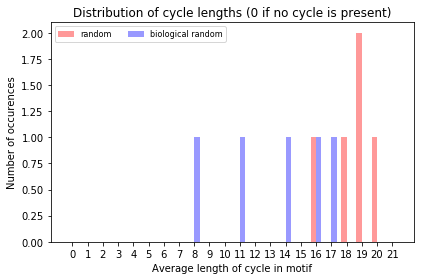

Using 4 nodes, 2-valued logic, and 0.5-epsilon 4-target nudge


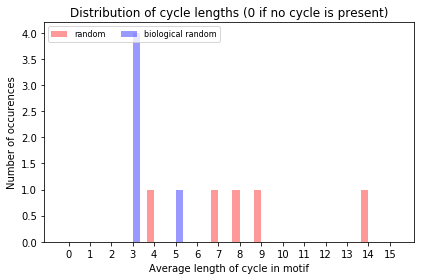

In [5]:
for i in range(0, len(samples)):
    args = (samples[i]["network_size"], samples[i]["logic_size"], samples[i]["nudge_size"], sample[2][-1][0])
    print("Using %s nodes, %s-valued logic, and %s-epsilon %s-target nudge" % args)
    random_cycles = []
    bio_cycles = []
    for sample in samples[i]["random_tables"]:
        lengths = [len(x) for x in sample[0].is_cyclical()]
        if len(lengths) == 0:
            lengths = [0]
        avg_length = int(np.mean(lengths))
        random_cycles.append(avg_length)
    for sample in samples[i]["bio_tables"]:
        lengths = [len(x) for x in sample[0].is_cyclical()]
        if len(lengths) == 0:
            lengths = [0]
        avg_length = int(np.mean(lengths))
        bio_cycles.append(avg_length)
    
    colors = ["r", "b"]
    labels = ["random", "biological random"]
    title = "Distribution of cycle lengths (0 if no cycle is present)"
    axes_labels = ["Average length of cycle in motif", "Number of occurences"]
    visualize.plot_bar([random_cycles, bio_cycles], colors, labels, title, axes_labels=axes_labels)

# Examine a few motifs (draw)

In [6]:
for i in range(0, len(samples)):
    args = (samples[i]["network_size"], samples[i]["logic_size"])
    print("\nUsing %s nodes, %s-valued logic" % args)
    counter = 0
    for sample in samples[i]["bio_tables"]:
        print("\nExamining sample %d" % counter)
        print(sample[0].grn_vars["rules"])
        counter += 1
        if counter ==  3:
            break


Using 4 nodes, 3-valued logic

Examining sample 0
[{'inputs': [0], 'rulefunction': <function plus at 0x7f7b7c442398>, 'outputs': [1]}, {'inputs': [0], 'rulefunction': <function minus at 0x7f7b7c442410>, 'outputs': [3]}, {'inputs': [1], 'rulefunction': <function plus at 0x7f7b7c442398>, 'outputs': [0]}, {'inputs': [2], 'rulefunction': <function minus at 0x7f7b7c442410>, 'outputs': [0]}, {'inputs': [2], 'rulefunction': <function minus at 0x7f7b7c442410>, 'outputs': [1]}, {'inputs': [3], 'rulefunction': <function plus at 0x7f7b7c442398>, 'outputs': [1]}, {'inputs': [3], 'rulefunction': <function minus at 0x7f7b7c442410>, 'outputs': [3]}, {'inputs': [1, 2], 'rulefunction': <function min_and at 0x7f7b7c442578>, 'outputs': [2]}]

Examining sample 1
[{'inputs': [0], 'rulefunction': <function minus at 0x7f7b7c442410>, 'outputs': [0]}, {'inputs': [0], 'rulefunction': <function minus at 0x7f7b7c442410>, 'outputs': [2]}, {'inputs': [1], 'rulefunction': <function minus at 0x7f7b7c442410>, 'output

# Examine a few initial matrices

In [15]:
for i in range(0, len(samples)):
    args = (samples[i]["network_size"], samples[i]["logic_size"])
    print("\nUsing %s nodes, %s-valued logic" % args)
    counter = 0
    for sample in samples[i]["bio_tables"]:
        print("\nExamining sample %d\n" % counter)
        print(sample[0].grn_vars["correlations"])
        print("\n")
        print(sample[0].states[0])
        counter += 1
        if counter == 1:
            break
    counter = 0
    for sample in samples[i]["bio_tables"]:
        print("\nExamining sample %d\n" % counter)
        print(sample[0].grn_vars["correlations"])
        print("\n")
        print(sample[0].states[0])
        counter += 1
        if counter == 1:
            break


Using 4 nodes, 3-valued logic

Examining sample 0

[[1.0, -0.281481457413865, -0.06853880617191987, -0.10668767211651838], [-0.281481457413865, 1.0, 0.21549572204304446, 0.13645104988720358], [-0.06853880617191987, 0.21549572204304446, 1.0, -0.4754614714544123], [-0.10668767211651838, 0.13645104988720358, -0.4754614714544123, 1.0]]


[[[[  1.81444972e-02   6.63006291e-03   2.42662400e-02]
   [  7.80976553e-03   9.89219898e-03   1.67921077e-02]
   [  6.39993548e-03   1.47624383e-02   1.78678653e-03]]

  [[  6.21929083e-03   1.04585835e-02   1.47264458e-02]
   [  1.99307226e-02   1.50372776e-02   2.37116365e-03]
   [  1.75883415e-02   1.63579551e-02   6.64563812e-03]]

  [[  2.25815666e-02   7.90402406e-03   1.89847260e-02]
   [  5.66013964e-03   2.59390931e-02   7.22139932e-03]
   [  2.23142317e-02   2.53574132e-02   2.06258242e-02]]]


 [[[  2.26998706e-02   2.55712892e-02   1.31565613e-02]
   [  4.74152824e-03   1.06961502e-02   1.22538767e-02]
   [  3.67697190e-03   1.27997520e-02  

# Known cases (transition tables)

Valideer measures op wat random motieven: synergy/and/copy.

The states: 
[[ 0.3044471   0.3816744 ]
 [ 0.03758199  0.27629651]]
[[ 0.58074361  0.0]
 [ 0.0  0.41925639]]
The correlations: 
[[1.0, -0.19767664236828497], [-0.19767664236828497, 1.0]]
Transitions: 
[[1, 1, 0, 0], [1, 0, 1, 1], [0, 1, 1, 1], [0, 0, 0, 0]]
The entropy: 
1.74335287393
The mutual information: 
0.981105987151
The WMS information: 
0.748929183124
The middle ground synergy approximation: 
0.782767438397
The memory: 
[1.7433528739307069, 0.98110598715099589149]
The nudge impact: 
0.118488331421


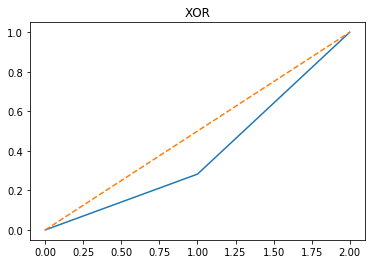

In [8]:
import discrete_motif_measures as measures
import discrete_motif_operations as operations

# XOR
motif = generator.generate_random(samplesize=1, no_nodes=2, numvalues=2)[0]
motif.transition_table = [[1, 1, 0, 0],[1, 0, 1, 1], [0, 1, 1, 1], [0, 0, 0, 0]]
motif.evaluate_motif()
print("The states: ")
for state in motif.states:
    print(state)
print("The correlations: ")
print(motif.grn_vars["correlations"])
print("Transitions: ")
print(motif.transition_table)

print("The entropy: ")
print(motif.entropy())
print("The mutual information: ")
print(measures.mutual_information(motif))
print("The WMS information: ")
print(measures.synergy_wms(motif))
print("The middle ground synergy approximation: ")
print(measures.synergy_middleground(motif))
print("The memory: ")
motif.reset_to_state(0)
print(measures.mi_decay(motif, 1))
motif.reset_to_state(0)
operations.nudge_variable(motif, [0], 0.5, 'DJ')
motif.evaluate_motif()
print("The nudge impact: ")
print(measures.hellinger(motif.states[1], motif.states[-1]))

visualize.plot_mi_profile([motif], "XOR", mode='maximum')

The states: 
[[ 0.02024021  0.21641751]
 [ 0.41186396  0.35147832]]
[[ 0.020240208  0.21641751]
 [ 0.41186396  0.35147832]]
The correlations: 
[[1.0, 0.12443320485879705], [0.12443320485879705, 1.0]]
Transitions: 
[[1, 1, 1, 1], [1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 0, 0]]
The entropy: 
1.64904753232
The mutual information: 
1.64904753232
The WMS information: 
0.267670983056
The middle ground synergy approximation: 
0.465030447199
The memory: 
[1.6490475323209957, 1.6490475323209957078]
The nudge impact: 
0.40462769104


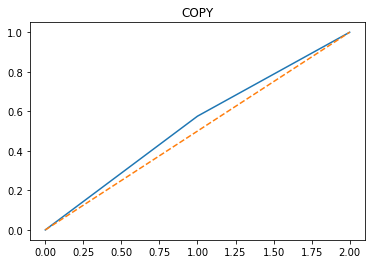

In [9]:
# COPY
motif = generator.generate_random(samplesize=1, no_nodes=2, numvalues=2)[0]
motif.transition_table = [[1, 1, 1, 1],[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 0, 0]]
motif.evaluate_motif()
print("The states: ")
for state in motif.states:
    print(state)
print("The correlations: ")
print(motif.grn_vars["correlations"])
print("Transitions: ")
print(motif.transition_table)

print("The entropy: ")
print(motif.entropy())
print("The mutual information: ")
print(measures.mutual_information(motif))
print("The WMS information: ")
print(measures.synergy_wms(motif))
print("The middle ground synergy approximation: ")
print(measures.synergy_middleground(motif))
print("The memory: ")
motif.reset_to_state(0)
print(measures.mi_decay(motif, 1))
motif.reset_to_state(0)
operations.nudge_variable(motif, [0], 0.5, 'DJ')
motif.evaluate_motif()
print("The nudge impact: ")
print(measures.hellinger(motif.states[1], motif.states[-1]))

visualize.plot_mi_profile([motif], "COPY", mode='maximum')

The states: 
[[ 0.26005013  0.01266623]
 [ 0.43559982  0.29168381]]
[[ 0.27271637  0.0]
 [ 0.43559982  0.29168381]]
The correlations: 
[[1.0, 0.06540211134881657], [0.06540211134881657, 1.0]]
Transitions: 
[[1, 1, 1, 1], [1, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 0]]
The entropy: 
1.62587299843
The mutual information: 
1.55194016046
The WMS information: 
0.300299305004
The middle ground synergy approximation: 
0.503451980928
The memory: 
[1.6258729984277696, 1.5519401604585725757]
The nudge impact: 
0.379055843467


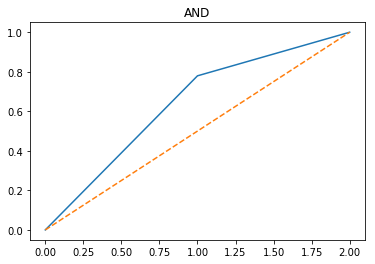

In [10]:
# AND
motif = generator.generate_random(samplesize=1, no_nodes=2, numvalues=2)[0]
motif.transition_table = [[1, 1, 1, 1],[1, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 0]]
motif.evaluate_motif()
print("The states: ")
for state in motif.states:
    print(state)
print("The correlations: ")
print(motif.grn_vars["correlations"])
print("Transitions: ")
print(motif.transition_table)

print("The entropy: ")
print(motif.entropy())
print("The mutual information: ")
print(measures.mutual_information(motif))
print("The WMS information: ")
print(measures.synergy_wms(motif))
print("The middle ground synergy approximation: ")
print(measures.synergy_middleground(motif))
print("The memory: ")
motif.reset_to_state(0)
print(measures.mi_decay(motif, 1))
motif.reset_to_state(0)
operations.nudge_variable(motif, [0], 0.5, 'DJ')
motif.evaluate_motif()
print("The nudge impact: ")
print(measures.hellinger(motif.states[1], motif.states[-1]))

visualize.plot_mi_profile([motif], "AND", mode='maximum')